In [1]:
import jax.numpy as jnp
import jax
from fbpinns.problems import Problem

class Poisson1D(Problem):
    """
    Solves the 1D Poisson equation
        - u_xx = f(x,y)
    on the domain [0,1] with Dirichlet boundary conditions u = 0 on ∂Ω.

    We choose f(x,y) such that the exact solution is:
        u(x,y) = sin(πx)
    which implies f(x,y) = π²sin(πx).
    """

    @staticmethod
    def init_params(f_coeff=jnp.pi ** 2, sd=0.1):
        # 'dims': (ud, xd) => u is scalar (ud=1) and x is 2D (xd=2)
        static_params = {
            "dims": (1, 1),
            "f_coeff": f_coeff,  # coefficient in the forcing function f(x,y)
            "sd": sd
        }
        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        # --- Physics loss: sample interior points ---
        # x_batch_phys: an array of shape (n_phys, 2)
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0, (0, 0)), # u_xx
        )

        return [[x_batch_phys, required_ujs_phys],]
    
    @staticmethod
    def constraining_fn(all_params, x_batch, u):
        sd = all_params["static"]["problem"]["sd"]
        x, tanh = x_batch[:,0:1], jax.nn.tanh
        u = tanh((x)/sd) * tanh((1-x)/sd) * u
        return u

    @staticmethod
    def loss_fn(all_params, constraints):
        # --- Physics loss ---
        # For the physics group, the constraints have been replaced with the evaluated quantities:
        # [x_batch_phys, u_xx, u_yy]
        x_phys, u_xx = constraints[0]
        x = x_phys[:, 0:1]

        # Compute the forcing term f(x,y) = 2π² sin(πx) sin(πy)
        f_coeff = all_params["static"]["problem"]["f_coeff"]
        f_val = f_coeff * jnp.sin(jnp.pi* x)

        # The physics residual is: u_xx + u_yy + f(x,y)
        phys_residual = u_xx + f_val

        return jnp.mean(phys_residual ** 2)

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        # The exact solution is u(x,y) = sin(πx) sin(πy)
        x = x_batch[:, 0:1]
        u = jnp.sin(jnp.pi* x)
        return u
    

[INFO] 2025-04-01 13:59:17 - <fbpinns.constants.Constants object at 0x7ed296567e30>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0.]), 'xmax': array([1.])}
problem: <class '__main__.Poisson1D'>
problem_init_kwargs: {}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])], 'subdomain_ws': [array([0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222,
       0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222])], 'unnorm': (0.0, 1.0)}
network: <class 'fbpinns.networks.ChebyshevKAN'>
network_init_kwargs: {'input_dim': 1, 'output_dim': 1, 'degree': 10}
n_steps: 15000
scheduler: <class 'fbpinns.schedulers.AllActiveSchedulerND'>
scheduler_kwargs: {}
ns: ((100,),)
n_test: (100,)
sampler: grid
optimiser: <function adam at 0x7ed32

[INFO] 2025-04-01 13:59:18 - Total number of constraints: 1
[INFO] 2025-04-01 13:59:18 - Computing exact solution..
[INFO] 2025-04-01 13:59:18 - Computing done
[INFO] 2025-04-01 13:59:18 - Getting test data inputs..
[INFO] 2025-04-01 13:59:20 - [i: 0/15000] Updating active inputs..
[INFO] 2025-04-01 13:59:20 - [i: 0/15000] Average number of points/dimension in active subdomains: 27.20
[INFO] 2025-04-01 13:59:20 - [i: 0/15000] Updating active inputs done (0.53 s)
[INFO] 2025-04-01 13:59:20 - [i: 0/15000] Compiling update step..
[INFO] 2025-04-01 13:59:20 - x_batch
[INFO] 2025-04-01 13:59:20 - (100, 1), float32, JVPTracer
[INFO] 2025-04-01 13:59:20 - x_take
[INFO] 2025-04-01 13:59:20 - (272, 1), float32, JVPTracer
[INFO] 2025-04-01 13:59:22 - [i: 0/15000] Compiling done (1.35 s)
(100, 1) (100, 1) (100, 1) (10, 100, 1) (10, 100, 1) (10, 100, 1) (100, 1) (100,)
True


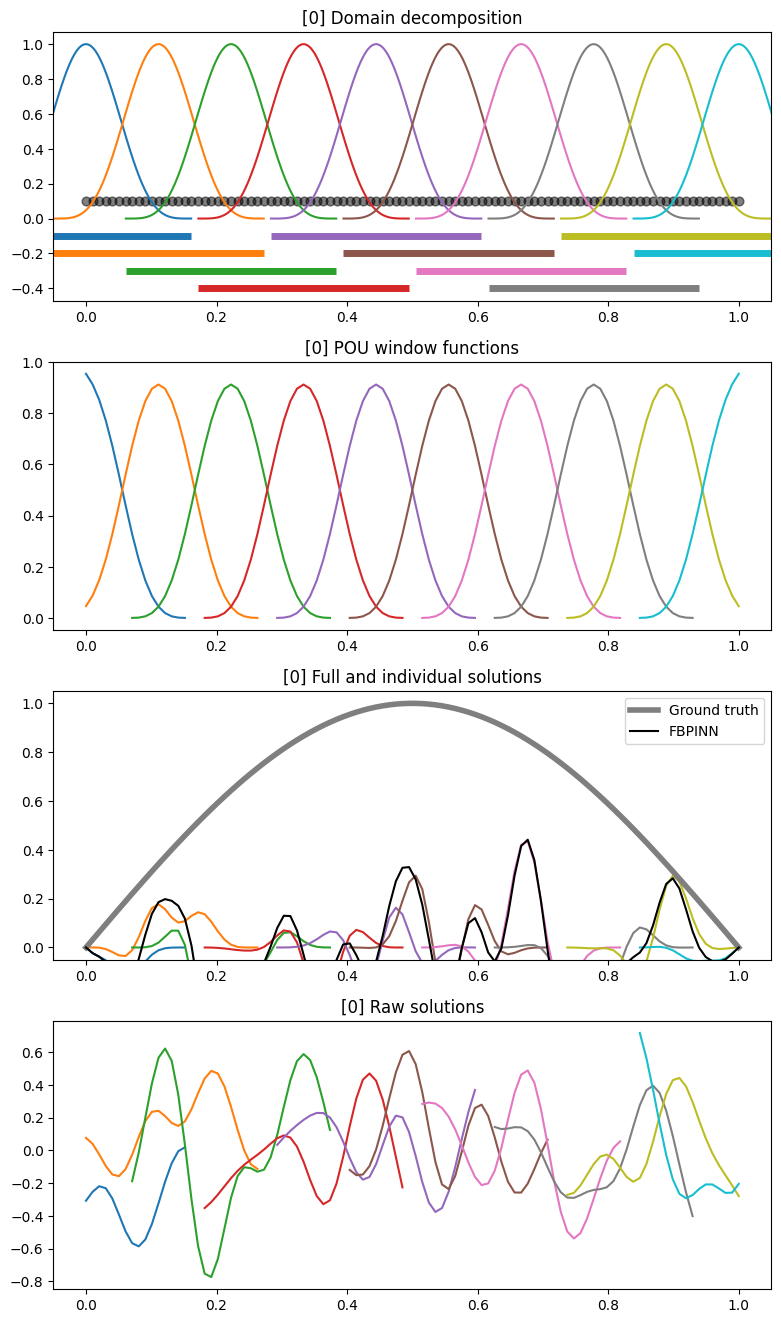

[INFO] 2025-04-01 13:59:25 - [i: 1000/15000] loss: 70.0544 rate: 505.6 elapsed: 0.00 hr test
[INFO] 2025-04-01 13:59:25 - [i: 2000/15000] loss: 55.9604 rate: 9564.4 elapsed: 0.00 hr test
[INFO] 2025-04-01 13:59:25 - [i: 3000/15000] loss: 46.8984 rate: 9299.0 elapsed: 0.00 hr test
[INFO] 2025-04-01 13:59:25 - [i: 4000/15000] loss: 38.0686 rate: 9205.8 elapsed: 0.00 hr test
[INFO] 2025-04-01 13:59:25 - [i: 5000/15000] loss: 28.5107 rate: 10132.0 elapsed: 0.00 hr test
(100, 1) (100, 1) (100, 1) (10, 100, 1) (10, 100, 1) (10, 100, 1) (100, 1) (100,)
True


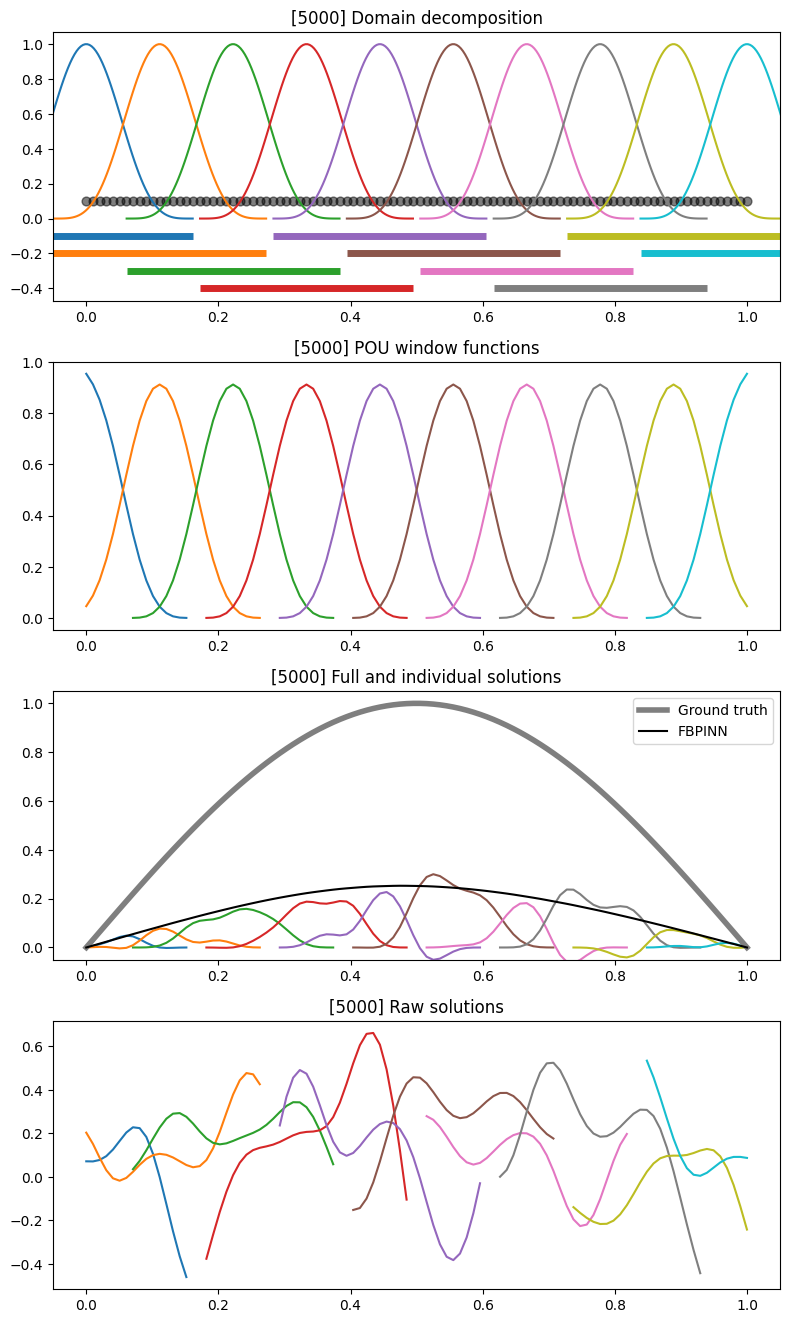

[INFO] 2025-04-01 13:59:26 - [i: 6000/15000] loss: 18.4381 rate: 9642.9 elapsed: 0.00 hr test
[INFO] 2025-04-01 13:59:26 - [i: 7000/15000] loss: 9.3578 rate: 10319.6 elapsed: 0.00 hr test
[INFO] 2025-04-01 13:59:26 - [i: 8000/15000] loss: 3.3966 rate: 9651.6 elapsed: 0.00 hr test
[INFO] 2025-04-01 13:59:26 - [i: 9000/15000] loss: 1.0709 rate: 10239.2 elapsed: 0.00 hr test
[INFO] 2025-04-01 13:59:27 - [i: 10000/15000] loss: 0.5949 rate: 10341.0 elapsed: 0.00 hr test
(100, 1) (100, 1) (100, 1) (10, 100, 1) (10, 100, 1) (10, 100, 1) (100, 1) (100,)
True


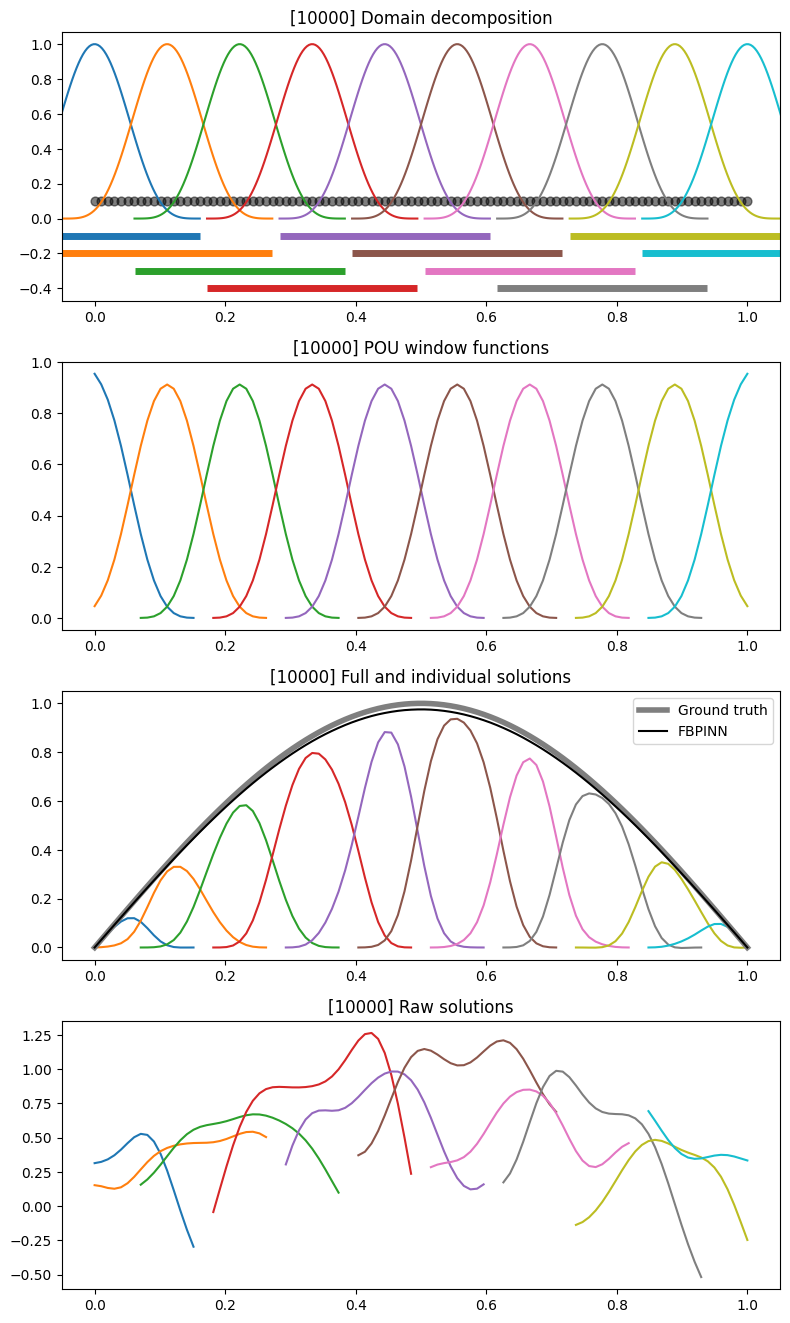

[INFO] 2025-04-01 13:59:27 - [i: 11000/15000] loss: 0.4734 rate: 10653.7 elapsed: 0.00 hr test
[INFO] 2025-04-01 13:59:27 - [i: 12000/15000] loss: 0.3644 rate: 10421.1 elapsed: 0.00 hr test
[INFO] 2025-04-01 13:59:28 - [i: 13000/15000] loss: 0.4557 rate: 10184.5 elapsed: 0.00 hr test
[INFO] 2025-04-01 13:59:28 - [i: 14000/15000] loss: 0.3276 rate: 10702.3 elapsed: 0.00 hr test
[INFO] 2025-04-01 13:59:28 - [i: 15000/15000] loss: 0.1620 rate: 10725.3 elapsed: 0.00 hr test
(100, 1) (100, 1) (100, 1) (10, 100, 1) (10, 100, 1) (10, 100, 1) (100, 1) (100,)
True


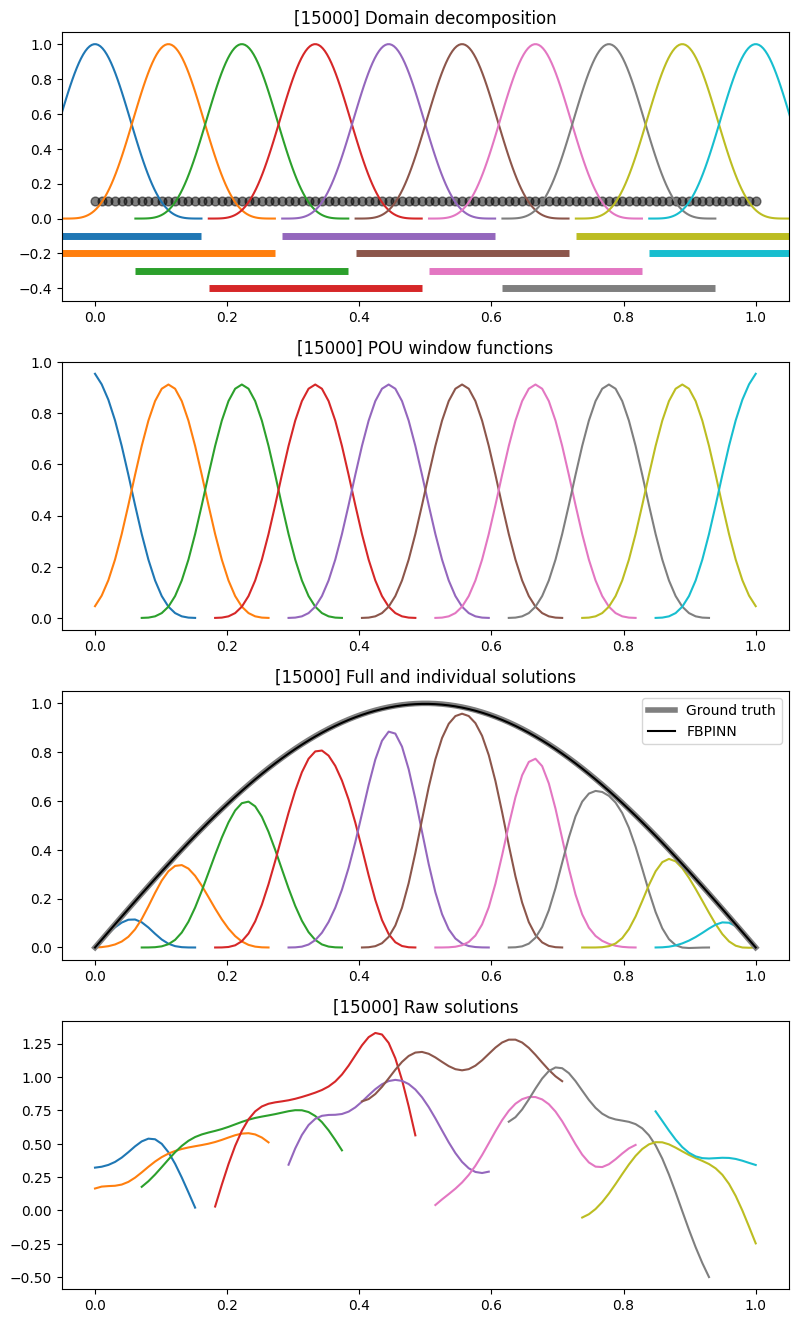

[INFO] 2025-04-01 13:59:28 - [i: 15000/15000] Training complete


In [3]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.problems import BurgersEquation2D
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import ChebyshevKAN, FCN, LegendreKAN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer

subdomain_xs=[np.linspace(0,1,10)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([0.,]),
        xmax=np.array([1.,])
        ),
    problem=Poisson1D,
    problem_init_kwargs = dict(),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0., 1.),
    ),
    # network=FCN,
    # network_init_kwargs = dict(
    #     layer_sizes = (2, 16, 16, 1),
    # ),
    # network=LegendreKAN,
    network=ChebyshevKAN,
    network_init_kwargs=dict(
        input_dim=1,
        output_dim=1,
        degree=10
    ),
    # scheduler = LineSchedulerRectangularND,
    # scheduler_kwargs = dict(
    #     point=[0.], iaxis=0,
    # ),
    # First element: interior sampling shape for the physics loss (here 200 x 200 points)
    # Second element: boundary sampling shapes; for 2D, we need 4 tuples (one for each boundary)
    ns=((100,),),
    # n_test provides the test sampling shape for the interior (here also 200 x 200)
    n_test=(100,),
    n_steps=15000,
    clear_output=False,
)

run = FBPINNTrainer(c)
all_params = run.train()